In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace, Operator, DensityMatrix
from qiskit.compiler import transpile, assemble
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Gray code and partition functions
def gray_code(n):
    if n == 0:
        return ['']
    first_half = gray_code(n - 1)
    second_half = first_half[::-1]
    return ['0' + code for code in first_half] + ['1' + code for code in second_half]

def get_partitions_and_reordered_indices(n):
    gray_codes = gray_code(n)
    reordered_indices = [int(code, 2) for code in gray_codes[1:]]
    partitions = {}
    for index in reordered_indices:
        msb = index.bit_length() - 1
        if msb not in partitions:
            partitions[msb] = []
        partitions[msb].append(index)
    return partitions, reordered_indices

In [2]:
# code for W
def W(qc, alpha, total_qubits, w_layers, inverse=False):
    idx = 0
    for layer in range(w_layers):
        for qubit in range(total_qubits):
            qc.rx(alpha[qubit+idx], qubit)
            idx = idx +1
            qc.ry(alpha[qubit+idx], qubit)
            idx = idx +1
            qc.rz(alpha[qubit+idx], qubit)
        for qubit in range(total_qubits):
            qc.cx(qubit, (qubit + layer + 1)%total_qubits)
        idx = 3*total_qubits*(layer+1)
    if inverse:
            qc = qc.inverse()
    return qc

In [3]:
# code for D
def D(qc,partitions, parameters, reordered_indices, total_qubits, h_layers):
    count = 0
    n = total_qubits
    N = 2**n
    lidx = 0
    for h in range(h_layers):
        for i in range(n):
            # Apply CNOT at the starting
            if count > 0:
                b = 2**i - 1
                xor = partitions[i][0] ^ partitions[i][b]
                l = int(np.log2(xor))
                qc.cx(l, i)
            for j in partitions[i]:
                # Apply the Rz gate
                qc.rz(-2*parameters[j-1+lidx], i)
                # Apply the CNOT gates in between
                if 0 < count < N - 2:
                    if j != 2**i:   
                        xor = reordered_indices[count] ^ reordered_indices[count + 1]
                        l = int(np.log(xor))
                        qc.cx(l, i)
                count += 1
        lidx = N-1+lidx
        count = 0
    return qc

In [4]:
def V(qc,param, total_qubits, W_layers,partitions, reordered_indices, h_layers):
    p = 3*total_qubits*W_layers
    W(qc, param[:p], total_qubits, W_layers, inverse=False)
    D(qc,partitions, param[p:], reordered_indices, total_qubits,h_layers)
    W(qc, param[:p], total_qubits, W_layers, inverse=True)
    return qc

In [5]:
# code for the trainability of the ansatz
t_sys_qubit = 2
t_env_qubit = 1
t_total_qubit = 3
w_layers = 2
h_layers = 2
t_param = [Parameter(f'theta{i}') for i in range(3*w_layers*t_total_qubit+((2**t_total_qubit)-1)*h_layers)]
t_qc = QuantumCircuit(t_total_qubit)
t_partitions, t_reordered_indices = get_partitions_and_reordered_indices(t_total_qubit)
t_qc = V(t_qc,t_param, t_total_qubit, w_layers,t_partitions, t_reordered_indices, h_layers) 
t_initial_param = [np.random.uniform(0, 4 * np.pi) for i in t_param]
t_initial_state = []
t_initial_state.append(DensityMatrix.from_label('110').data)
t_initial_state.append(DensityMatrix.from_label('110').data)
t_projected_state = []
t_projected_state.append(DensityMatrix.from_label('0').data)
t_projected_state.append(DensityMatrix.from_label('1').data)
t_prob = np.zeros((2, 2))
t_T=[1]
for i in range(2):
    t_prob[i, 0] = np.random.rand() 
    t_prob[i, 1] = 1 - t_prob[i, 0]
t_loss =[]
t_p = 3*w_layers*t_total_qubit
print(t_prob)
def loss(parameters):
    parameters_array = np.array(parameters)
    prob1 = []
    for t in t_T:
        param_val = parameters_array
        param_val[t_p:] = param_val[t_p:]*t
        dictionary = dict(zip(t_param,param_val))
        bc = t_qc.assign_parameters(dictionary)
        matrix = Operator(bc).data
        matrix_inv = Operator(bc.inverse()).data
        state = []
        for i in t_initial_state:
            state.append(matrix@i@matrix_inv)
        state[0] = partial_trace(state[0],[1,2])
        state[1] = partial_trace(state[1],[0,2])
        prob1.append([[np.real(np.trace(state[i]@t_projected_state[j]))for j in range(2)]for i in range(2)])

    prob1_clip = np.clip(prob1, 1e-10, 1)
    loss = 0

    for j in range(2):
        for k in range(2):
            loss = loss + prob1_clip[0][j][k]*np.log(prob1_clip[0][j][k]/t_prob[j][k])
    print(loss)
    t_loss.append(loss)
    print()
    return loss  



# Define the initial guess for the parameters
initial_guess = t_initial_param

# Define the block size (30 parameters at a time)
block_size = 17

# Define the number of blocks
num_blocks = int(np.ceil((len(t_param))/ block_size))

# Optimize each block of parameters
for iteration in range(1):  # Repeat the optimization process 10 times
    for i in range(num_blocks):
        block_start = i * block_size
        block_end = min((i + 1) * block_size, len(t_param))
        block_initial_guess = initial_guess[block_start:block_end]
        
        def block_objective_function(block_params):
            initial_guess[block_start:block_end] = block_params
            return loss(initial_guess)
        
        res = minimize(block_objective_function, block_initial_guess, method="COBYLA", bounds=None)
        initial_guess[block_start:block_end] = res.x
        
        # Print some logging information
        print(f"Iteration {iteration}, Block {i}: {res.fun:.4f}")

# Print the optimized parameters
print(initial_guess)

# Print the minimum value of the objective function
print(loss(initial_guess))

[[0.51309081 0.48690919]
 [0.1291754  0.8708246 ]]
0.156726383660181

0.2888894152748993

0.26355569826993663

0.20905828458853817

0.11847219442645365

0.27170329198589993

0.22207370139810442

0.13102698609023078

0.40381779826251346

0.1680356082444562

0.06628757869737562

0.45283093625298604

0.13133912573443252

0.31898827692015114

0.6690828993097699

0.06675818874876177

0.375589541328462

0.3734410793898698

0.0680642130060255

0.025217434593703375

0.0437338664896683

0.02945183476037823

0.026746067152295758

0.10703809284082086

0.008771608241226483

0.007352124769519672

0.021209618784067442

0.024180604572073466

0.004574163938945698

0.0013750313291048801

0.004175074998043255

0.01841127916834964

0.007604166073631874

0.05718547935899716

0.0008288040795274877

0.002573776202275075

0.007006124308780361

0.036050658022983254

0.005575554781812583

0.07167889750881579

0.04018577311849191

0.0037977975559458747

0.001074446426912316

0.007647538124927487

0.001560073866

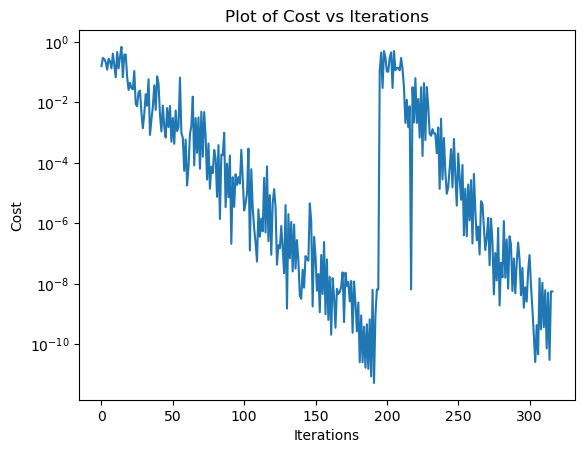

In [6]:
plt.semilogy(t_loss)

# Add a title and labels
plt.title('Plot of Cost vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')

plt.savefig('train', dpi=300, bbox_inches='tight')
plt.show()